In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML
from findiff import FinDiff, PDE, BoundaryConditions
import importlib

import linear_jax as linear
# import linear

In [2]:
# Generate data from heat equation

# Set config params
grid_size = 50
time_size = 20
W_amp = 0

# Init fd = y = np.linspace(0, 1, grid_size)
t = np.linspace(0, 1, time_size)
x = np.linspace(0, 1, grid_size)
X, T = np.meshgrid(t, x, indexing='ij')
X_test = np.stack([T.flatten(), X.flatten()], axis=1)
shape = (time_size, grid_size)
dt = t[1]-t[0]
dx = x[1]-x[0]

In [3]:
# Set LHS
alpha = 0.05
diff_op = FinDiff(0, dt, 1) - alpha * FinDiff(1, dx, 2)

# Set RHS
np.random.seed(13)
W = W_amp * np.random.randn(*shape)

# Set boundary conditions (Dirichlet)
bc = BoundaryConditions(shape)
for i in range(grid_size):
    normal_pdf = np.exp(- ((x[i] - 0.5) / 0.1) ** 2)
    bc[0,i] = normal_pdf
bc[:,0] = 0
bc[:,-1] = 0

# Solve PDE
pde = PDE(diff_op, W, bc)
u = pde.solve()

In [4]:
# Set LHS
alpha = 0.05
diff_op = FinDiff(0, dt, 1) - alpha * FinDiff(1, dx, 2)

# Set RHS
np.random.seed(13)
W = W_amp * np.random.randn(*shape)

# Set boundary conditions (Dirichlet)
bc = BoundaryConditions(shape)
for i in range(grid_size):
    normal_pdf = 1 if (i > 20 and i < 30) else 0
    bc[0,i] = normal_pdf
bc[:,0] = 0
bc[:,-1] = 0

# Solve PDE
pde = PDE(diff_op, W, bc)
u_step = pde.solve()

Text(0.5, 1.0, 'Ground truth')

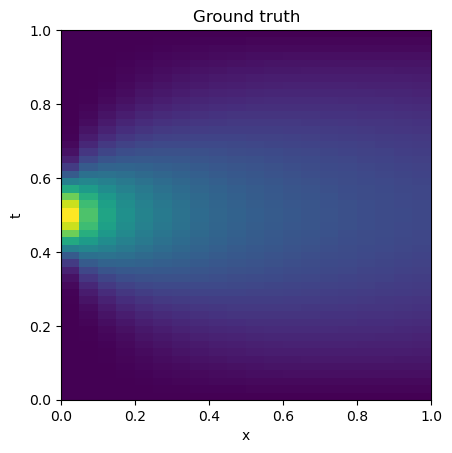

In [5]:
fig = plt.figure()
ax = plt.axes(xlim=(0, 1), ylim=(0, 1))
ax.imshow(u.T, extent=[0,1,1,0])
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_title('Ground truth')

Text(0.5, 0.92, 'Smooth IC')

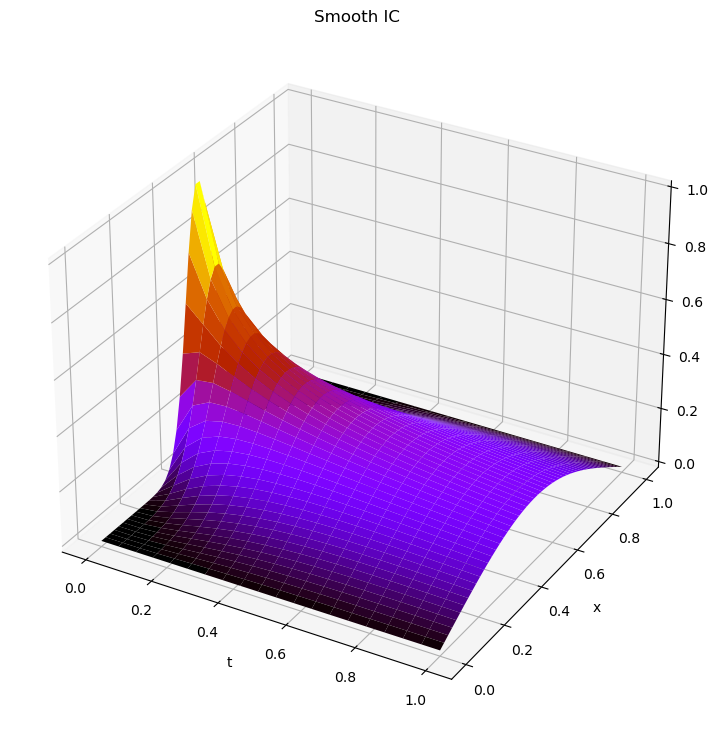

In [6]:
from matplotlib import cm
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(10,9))
surf = ax.plot_surface(X, T, u, cmap=cm.gnuplot)
ax.set_zlim([0,1])
ax.set_xlabel('t')
ax.set_ylabel('x')
ax.set_title('Smooth IC')
# fig.colorbar(surf)

Text(0.5, 0.92, 'Step IC')

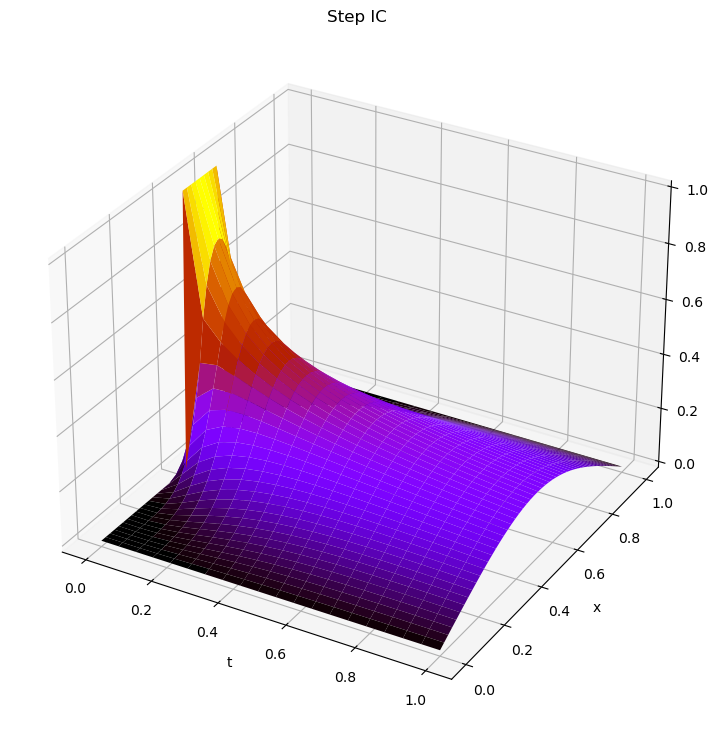

In [7]:

fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(10,9))
surf = ax.plot_surface(X, T, u_step, cmap=cm.gnuplot)
ax.set_xlabel('t')
ax.set_ylabel('x')
ax.set_title('Step IC')
# fig.colorbar(surf)

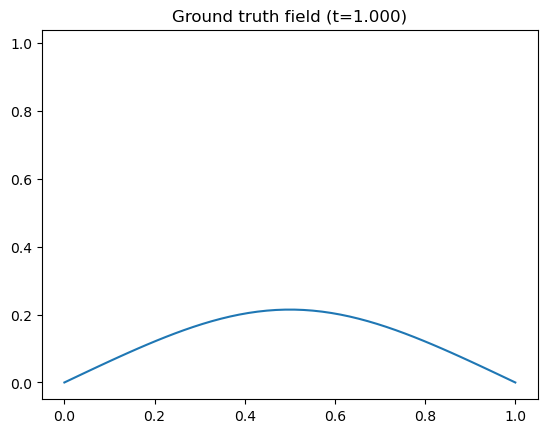

In [8]:
# Create animation
fig = plt.figure()
ax = plt.axes()
# ax = plt.axes(xlim=(0, 1), ylim=(0, 1))
line, = ax.plot(x, u[0])

def animate(i):
    line.set_ydata(u[i])
    ax.set_title(f'Ground truth field (t={(dt*i):02.3f})')
    return line,

anim = animation.FuncAnimation(fig, animate, frames=time_size, interval=100, blit=True)
HTML(anim.to_jshtml())

In [9]:
obs_noise = 1e-4
obs_count = 100
obs_dict = linear.sample_observations(u_step, obs_count, obs_noise)
obs_idxs = np.array(list(obs_dict.keys()), dtype=int)

AttributeError: module 'jax.numpy' has no attribute 'random'

In [10]:
diff_op_min = FinDiff(0, dt, 1) - alpha * FinDiff(1, dx, 2)
posterior_mean_pde, posterior_std_pde, _ = linear.fit_pde_gp(u, obs_dict, X_test, dx, dt, obs_noise, diff_op)
posterior_mean_min, posterior_std_min, _ = linear.fit_pde_gp(u, obs_dict, X_test, dx, dt, obs_noise, diff_op_min)
posterior_mean_rbf, posterior_std_rbf = linear.fit_rbf_gp(u, obs_dict, X_test, dx, dt, obs_noise)
print(linear.mse(u, posterior_mean_pde))
print(linear.mse(u, posterior_mean_rbf))
linear.plot_gp_2d(u.T, posterior_mean_pde.T, posterior_std_pde.T, linear.swap_cols(obs_idxs), 'figures/heat_eqn_test_pde.png',
                  mean_vmin=-0.05, mean_vmax=1, std_vmin=0, std_vmax=0.06,
                  diff_vmin=-0.3, diff_vmax=0.2)
linear.plot_gp_2d(u.T, posterior_mean_min.T, posterior_std_min.T, linear.swap_cols(obs_idxs), 'figures/heat_eqn_test_min.png',
                  mean_vmin=-0.05, mean_vmax=1, std_vmin=0, std_vmax=0.06,
                  diff_vmin=-0.3, diff_vmax=0.2)
linear.plot_gp_2d(u.T, posterior_mean_rbf.T, posterior_std_rbf.T, linear.swap_cols(obs_idxs), 'figures/heat_eqn_test_rbf.png',
                  mean_vmin=-0.05, mean_vmax=1, std_vmin=0, std_vmax=0.06, diff_vmin=-0.2, diff_vmax=0.055)

NameError: name 'obs_dict' is not defined

In [10]:
import jax


In [11]:
importlib.reload(linear)
num_samples = 30
alpha_guesses = np.linspace(0.03, 0.06, 10)
mses_step = np.empty((alpha_guesses.shape[0], num_samples))
nlls_step = np.empty((alpha_guesses.shape[0], num_samples))
for j in range(num_samples):
    obs_dict = linear.sample_observations(u_step, obs_count, obs_noise)
    for i, alpha_guess in enumerate(alpha_guesses):
        diff_op_guess = FinDiff(0, dt, 1) - alpha_guess * FinDiff(1, dx, 2)
        posterior_mean_pde, posterior_std_pde, nll = linear.fit_pde_gp(u_step, obs_dict, X_test, dx, dt, obs_noise, diff_op_guess)
        mses_step[i, j] = linear.mse(u_step, posterior_mean_pde)
        nlls_step[i, j] = nll
        print(f'alpha={alpha_guess:.4f}, MSE={mses_step[i, j]:.5f}, NLL={nlls_step[i, j]:.5f}')

alpha=0.0300, MSE=0.00114, NLL=-inf
alpha=0.0333, MSE=0.00108, NLL=-inf
alpha=0.0367, MSE=0.00105, NLL=-inf
alpha=0.0400, MSE=0.00105, NLL=-inf
alpha=0.0433, MSE=0.00107, NLL=-inf
alpha=0.0467, MSE=0.00114, NLL=-inf
alpha=0.0500, MSE=0.00128, NLL=-inf
alpha=0.0533, MSE=0.00150, NLL=-inf
alpha=0.0567, MSE=0.00179, NLL=-inf
alpha=0.0600, MSE=0.00214, NLL=-inf
alpha=0.0300, MSE=0.00135, NLL=-inf
alpha=0.0333, MSE=0.00117, NLL=-inf
alpha=0.0367, MSE=0.00106, NLL=-inf
alpha=0.0400, MSE=0.00101, NLL=-inf
alpha=0.0433, MSE=0.00100, NLL=-inf
alpha=0.0467, MSE=0.00101, NLL=-inf
alpha=0.0500, MSE=0.00103, NLL=-inf
alpha=0.0533, MSE=0.00106, NLL=-inf
alpha=0.0567, MSE=0.00110, NLL=-inf
alpha=0.0600, MSE=0.00115, NLL=-inf
alpha=0.0300, MSE=0.00167, NLL=-inf
alpha=0.0333, MSE=0.00172, NLL=-inf
alpha=0.0367, MSE=0.00190, NLL=-inf
alpha=0.0400, MSE=0.00217, NLL=-inf
alpha=0.0433, MSE=0.00243, NLL=-inf
alpha=0.0467, MSE=0.00263, NLL=-inf
alpha=0.0500, MSE=0.00279, NLL=-inf
alpha=0.0533, MSE=0.00294, N

In [12]:
importlib.reload(linear)
num_samples = 30
alpha_guesses = np.linspace(0.03, 0.06, 10)
mses_rbf = np.empty((alpha_guesses.shape[0], num_samples))
nlls_rbf = np.empty((alpha_guesses.shape[0], num_samples))
for j in range(num_samples):
    obs_dict = linear.sample_observations(u, obs_count, obs_noise)
    for i, alpha_guess in enumerate(alpha_guesses):
        diff_op_guess = FinDiff(0, dt, 1) - alpha_guess * FinDiff(1, dx, 2)
        posterior_mean_pde, posterior_std_pde, nll = linear.fit_pde_gp(u, obs_dict, X_test, dx, dt, obs_noise, diff_op_guess)
        mses_rbf[i, j] = linear.mse(u, posterior_mean_pde)
        nlls_rbf[i, j] = nll
        print(f'alpha={alpha_guess:.4f}, MSE={mses_rbf[i, j]:.5f}, NLL={nlls_rbf[i, j]:.5f}')

alpha=0.0300, MSE=0.00028, NLL=-inf
alpha=0.0333, MSE=0.00020, NLL=-inf
alpha=0.0367, MSE=0.00015, NLL=-inf
alpha=0.0400, MSE=0.00012, NLL=-inf
alpha=0.0433, MSE=0.00011, NLL=-inf
alpha=0.0467, MSE=0.00011, NLL=-inf
alpha=0.0500, MSE=0.00012, NLL=-inf
alpha=0.0533, MSE=0.00014, NLL=-inf
alpha=0.0567, MSE=0.00016, NLL=-inf
alpha=0.0600, MSE=0.00021, NLL=-inf
alpha=0.0300, MSE=0.00035, NLL=-inf
alpha=0.0333, MSE=0.00026, NLL=-inf
alpha=0.0367, MSE=0.00021, NLL=-inf
alpha=0.0400, MSE=0.00018, NLL=-inf
alpha=0.0433, MSE=0.00017, NLL=-inf
alpha=0.0467, MSE=0.00018, NLL=-inf
alpha=0.0500, MSE=0.00020, NLL=-inf
alpha=0.0533, MSE=0.00023, NLL=-inf
alpha=0.0567, MSE=0.00027, NLL=-inf
alpha=0.0600, MSE=0.00031, NLL=-inf
alpha=0.0300, MSE=0.00010, NLL=-inf
alpha=0.0333, MSE=0.00007, NLL=-inf
alpha=0.0367, MSE=0.00004, NLL=-inf
alpha=0.0400, MSE=0.00003, NLL=-inf
alpha=0.0433, MSE=0.00002, NLL=-inf
alpha=0.0467, MSE=0.00002, NLL=-inf
alpha=0.0500, MSE=0.00003, NLL=-inf
alpha=0.0533, MSE=0.00004, N

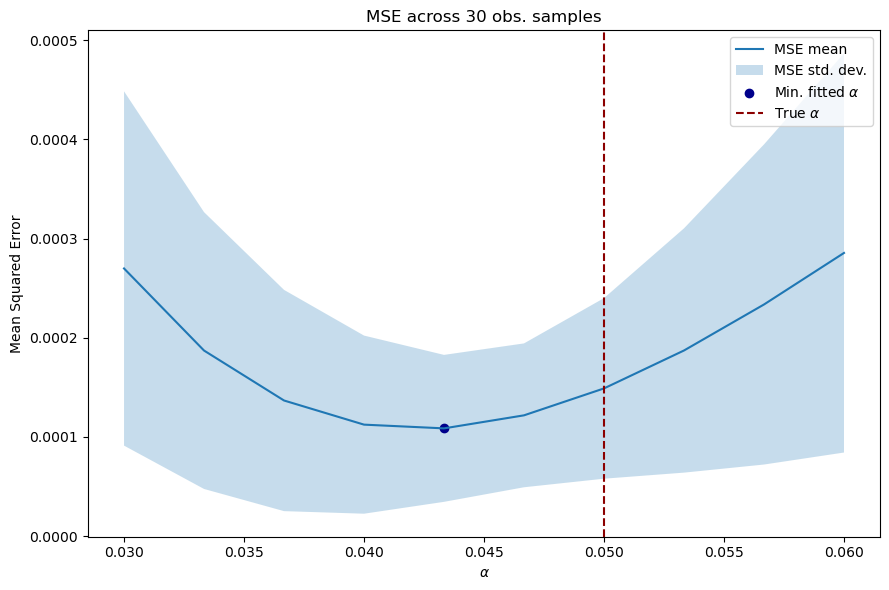

In [13]:
# mse_mean_step = mses_step.mean(axis=1)
# mse_std_step = mses_step.std(axis=1)
# min_alpha_step = alpha_guesses[np.argmin(mse_mean_step)]
mse_mean_rbf = mses_rbf.mean(axis=1)
mse_std_rbf = mses_rbf.std(axis=1)
min_alpha_rbf = alpha_guesses[np.argmin(mse_mean_rbf)]
# print(min_alpha_step, min_alpha_rbf)
plt.figure(figsize=(9,6))
# plt.plot(alpha_guesses, mse_mean_step, label=f"MSE mean")
# plt.fill_between(alpha_guesses, mse_mean_step + mse_std_step, mse_mean_step - mse_std_step, alpha=0.25, label=f"MSE std. dev.") 
# plt.scatter(min_alpha_step, np.min(mse_mean_step), color='darkblue', label="Min. fitted $\\alpha$")
plt.plot(alpha_guesses, mse_mean_rbf, label=f"MSE mean")
plt.fill_between(alpha_guesses, mse_mean_rbf + mse_std_rbf, mse_mean_rbf - mse_std_rbf, alpha=0.25, label=f"MSE std. dev.")
plt.scatter(min_alpha_rbf, np.min(mse_mean_rbf), color='darkblue', label="Min. fitted $\\alpha$")
plt.axvline(alpha, color='darkred', ls='--', label="True $\\alpha$")
plt.title(f"MSE across {num_samples} obs. samples")
plt.xlabel("$\\alpha$")
plt.ylabel("Mean Squared Error")
plt.legend()
plt.tight_layout()
plt.savefig("figures/mse_alpha_smooth.png", dpi=200)
plt.show()

0.03666666666666667 0.043333333333333335


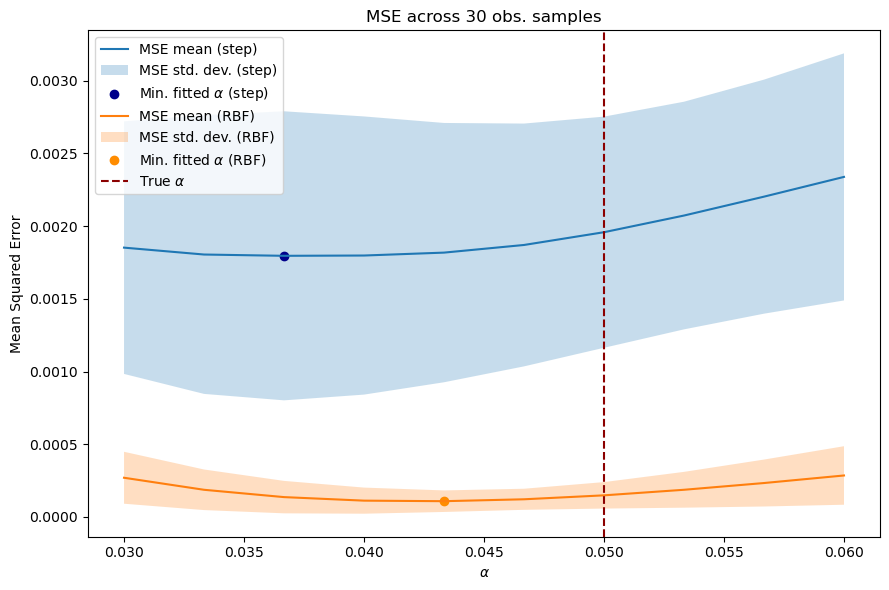

In [14]:
mse_mean_step = mses_step.mean(axis=1)
mse_std_step = mses_step.std(axis=1)
min_alpha_step = alpha_guesses[np.argmin(mse_mean_step)]
mse_mean_rbf = mses_rbf.mean(axis=1)
mse_std_rbf = mses_rbf.std(axis=1)
min_alpha_rbf = alpha_guesses[np.argmin(mse_mean_rbf)]
print(min_alpha_step, min_alpha_rbf)
plt.figure(figsize=(9,6))
plt.plot(alpha_guesses, mse_mean_step, label=f"MSE mean (step)")
plt.fill_between(alpha_guesses, mse_mean_step + mse_std_step, mse_mean_step - mse_std_step, alpha=0.25, label=f"MSE std. dev. (step)")
plt.scatter(min_alpha_step, np.min(mse_mean_step), color='darkblue', label="Min. fitted $\\alpha$ (step)")
plt.plot(alpha_guesses, mse_mean_rbf, label=f"MSE mean (RBF)")
plt.fill_between(alpha_guesses, mse_mean_rbf + mse_std_rbf, mse_mean_rbf - mse_std_rbf, alpha=0.25, label=f"MSE std. dev. (RBF)")
plt.scatter(min_alpha_rbf, np.min(mse_mean_rbf), color='darkorange', label="Min. fitted $\\alpha$ (RBF)")
plt.axvline(alpha, color='darkred', ls='--', label="True $\\alpha$")
plt.title(f"MSE across {num_samples} obs. samples")
plt.xlabel("$\\alpha$")
plt.ylabel("Mean Squared Error")
plt.legend()
plt.tight_layout()
plt.savefig("figures/mse_alpha_step.png", dpi=200)
plt.show()

In [15]:
nll_mean = nlls.mean(axis=1)
nll_std = nlls.std(axis=1)
plt.plot(alpha_guesses, nll_mean, label=f"NLL mean")
plt.fill_between(alpha_guesses, nll_mean + nll_std, nll_mean - nll_std, alpha=0.25, label=f"NLL std. dev.")
plt.axvline(alpha, color='darkred', ls='--', label="True $\\alpha$")
plt.title(f"NLL across {num_samples} obs. samples")
plt.xlabel("$\\alpha$")
plt.ylabel("Mean Squared Error")
plt.legend()
plt.savefig("figures/nll_alpha.png", dpi=200)
plt.show()

NameError: name 'nlls' is not defined

In [ ]:
obs_noise = 1e-4
obs_count = 100
obs_dict = linear.sample_observations(u_step, obs_count, obs_noise)
obs_idxs = np.array(list(obs_dict.keys()), dtype=int)

0.00010747947021777657
9.697345054616527e-05


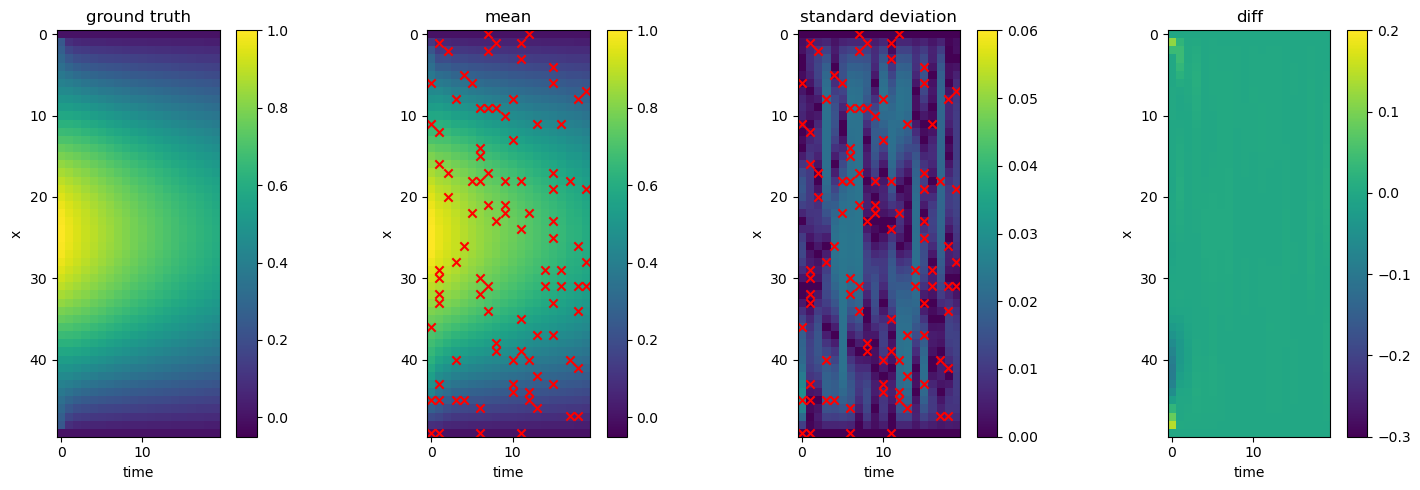

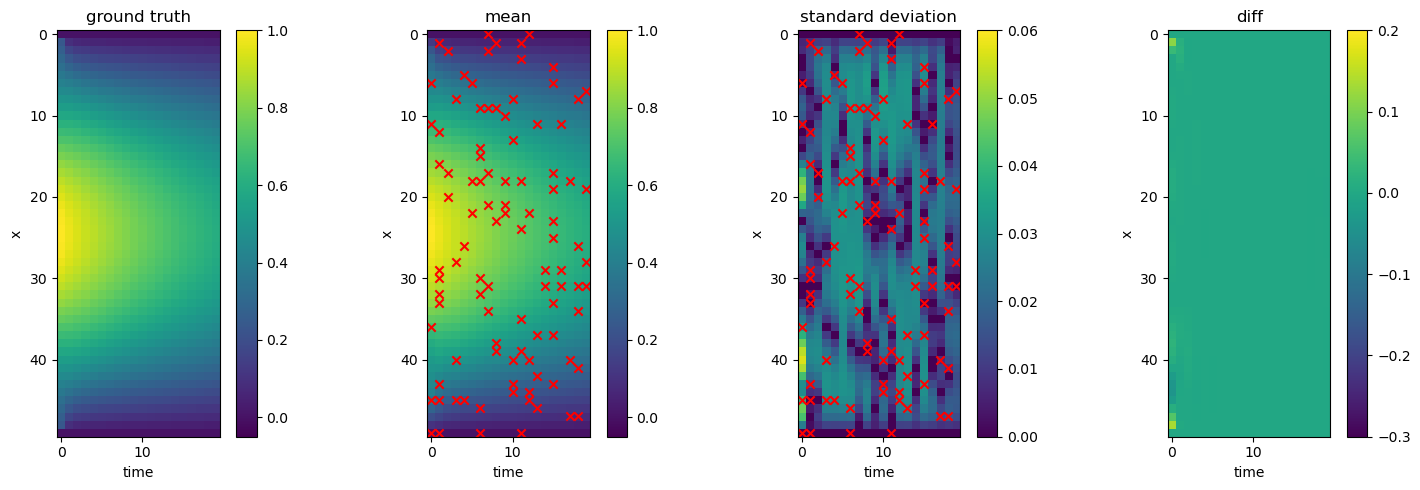

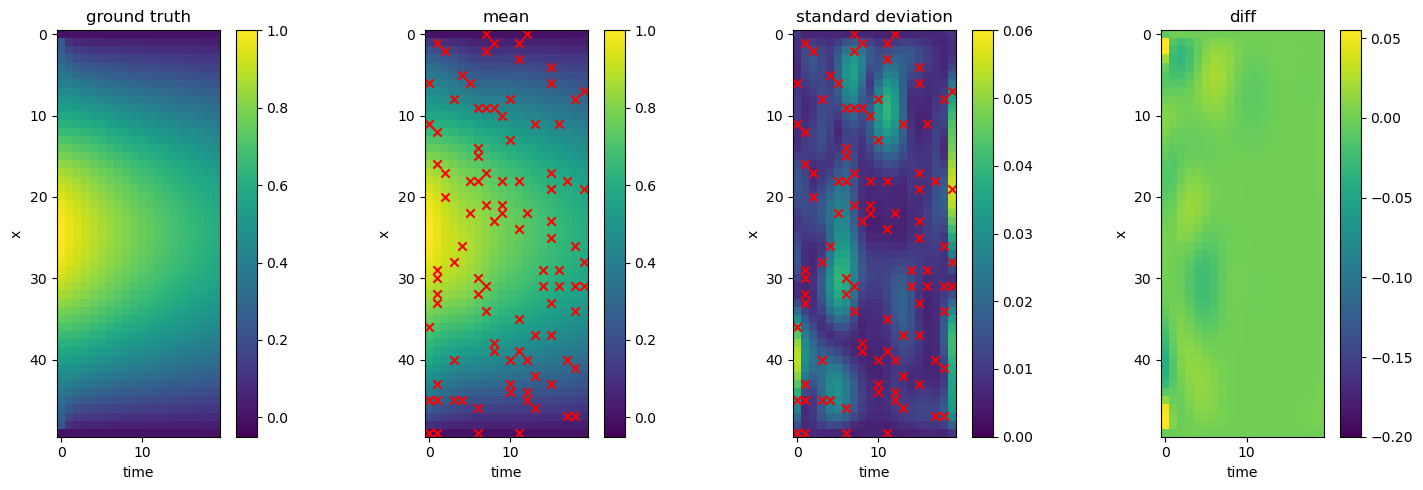

In [ ]:
diff_op_min = FinDiff(0, dt, 1) - min_alpha_rbf * FinDiff(1, dx, 2)
posterior_mean_pde, posterior_std_pde, _ = linear.fit_pde_gp(u, obs_dict, X_test, dx, dt, obs_noise, diff_op)
posterior_mean_min, posterior_std_min, _ = linear.fit_pde_gp(u, obs_dict, X_test, dx, dt, obs_noise, diff_op_min)
posterior_mean_rbf, posterior_std_rbf = linear.fit_rbf_gp(u, obs_dict, X_test, dx, dt, obs_noise)
print(linear.mse(u, posterior_mean_pde))
print(linear.mse(u, posterior_mean_rbf))
linear.plot_gp_2d(u.T, posterior_mean_pde.T, posterior_std_pde.T, linear.swap_cols(obs_idxs), 'figures/heat_eqn_test_pde.png',
                  mean_vmin=-0.05, mean_vmax=1, std_vmin=0, std_vmax=0.06,
                  diff_vmin=-0.3, diff_vmax=0.2)
linear.plot_gp_2d(u.T, posterior_mean_min.T, posterior_std_min.T, linear.swap_cols(obs_idxs), 'figures/heat_eqn_test_min.png',
                  mean_vmin=-0.05, mean_vmax=1, std_vmin=0, std_vmax=0.06,
                  diff_vmin=-0.3, diff_vmax=0.2)
linear.plot_gp_2d(u.T, posterior_mean_rbf.T, posterior_std_rbf.T, linear.swap_cols(obs_idxs), 'figures/heat_eqn_test_rbf.png',
                  mean_vmin=-0.05, mean_vmax=1, std_vmin=0, std_vmax=0.06, diff_vmin=-0.2, diff_vmax=0.055)

MovieWriter imagemagick unavailable; using Pillow instead.


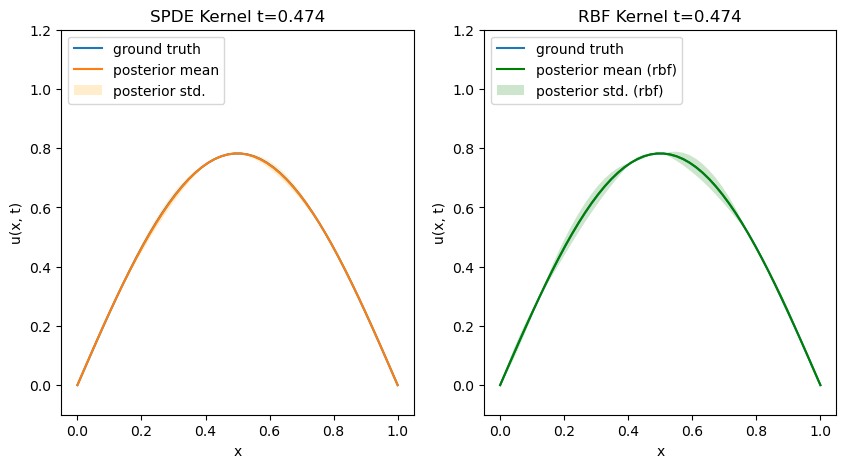

In [ ]:
importlib.reload(linear)
linear.create_HTML_animation(x, u, posterior_mean_pde, posterior_std_pde, posterior_mean_min, posterior_std_min, dt, "figures/heat_eqn_comparison.gif")